# **California housing:** *a Machine Learning implementation*

## Setup

In [1]:
# Importera bibliotek
# python -m pip install numpy pandas matplotlib seaborn scikit-learn ipykernel
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    roc_auc_score
)

In [2]:
# Reproducerbarhet
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# Ladda in housing.csv
import sys, os 
sys.path.append(os.path.abspath(".."))
df = pd.read_csv("./data/housing.csv")
df.tail(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


## Dataöversikt

In [3]:
print(f"Här är orginella features i bostadsdata:\n {list(df.columns)}\n")
print(f"Bostadsdata har storleken {df.shape}.")
print("\nKolumnerna har datatyperna:")
display(df.dtypes)

print("Beskrivande statistik på numerisk data:")
df.describe().round(2)

# Notera att huspriserna senare används för att flagga högpris-områden och sen utesluts.

Här är orginella features i bostadsdata:
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']

Bostadsdata har storleken (20640, 10).

Kolumnerna har datatyperna:


longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Beskrivande statistik på numerisk data:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


In [4]:
print("Vad för texter finns i kolumnen närhet till hav:")
display(pd.DataFrame(df['ocean_proximity'].value_counts()))

missing_vals = df.isna().sum()
print("Här är kolumner med antalet tomma rader:")
missing_vals[missing_vals > 0]

# Notera att om det saknas värden kan imputering behövas. Detta görs ofta genom att medianvärdet sätts in.

Vad för texter finns i kolumnen närhet till hav:


,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


Här är kolumner med antalet tomma rader:


total_bedrooms    207
dtype: int64

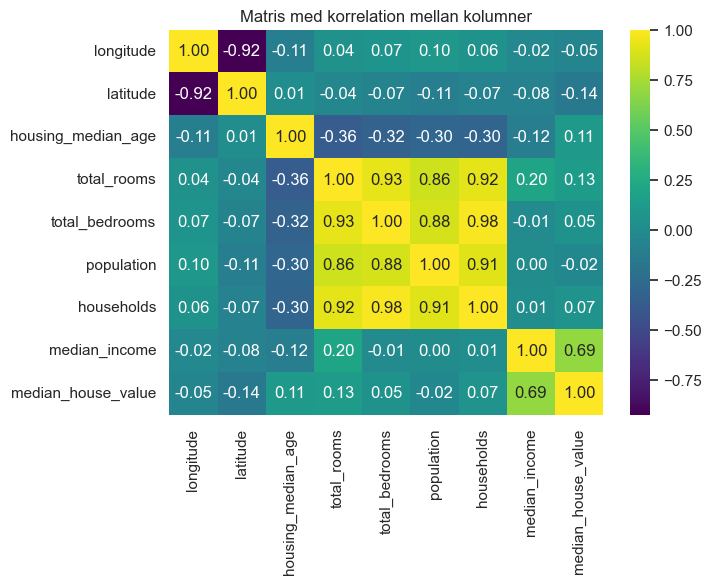

In [5]:
plt.figure(figsize=(7,5))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Matris med korrelation mellan kolumner")
plt.show()

I figuren ovan syns korrelation mellan kolumnerna i bostadsdata. Koordinater, antal rum samt befolkning och hushåll, och inkomst samt huspris har som grupperat nära länkade värden. Huspriset ska uteslutas och en kategori för områden som är högprisade eller inte ska istället vara fokus för prediktioner. Orginell data korrelerad såhär framstår rimligt.

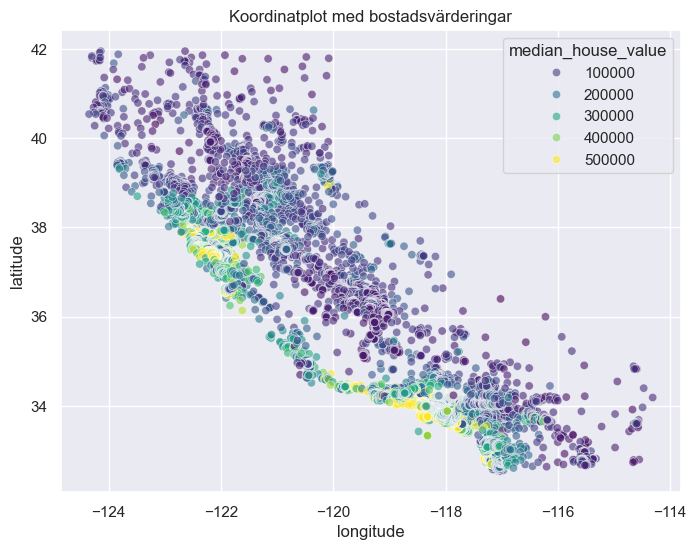

In [6]:
plt.figure(figsize=(8,6))
plt.title("Koordinatplot med bostadsvärderingar")
sns.scatterplot(x=df["longitude"], y=df["latitude"], hue=df["median_house_value"], alpha=0.6, palette="viridis")
plt.show()

En scatterplot med x- och y-koordinater tillsammans med huspriser för färgskala skissar upp bostadsdata för västkusten i USA. Det tycks billigare att bo inåt landet än längsmed kusten.

## Skapa target och Featureanpassning

Först gör vi en target kolumn `high_value` som sätter en etta ifall medianhusvärdet för raden tillhör de översta tjugo procenten, annars en nolla.

Sedan görs och sparas bråktal kolumner för rum per hus, sovrum per hus och befolkning per hus. Dessa ersätter summerande kolumnerna `total_rooms`, `total_bedrooms`, `population`, `households`. Viss förlust av skala kan inträffa medan jämförbarhet träder in. Skulle summerande kolumnerna sparas jämsides med bråktalen uppstår multikolinearitet och därigenom möjligen brus. Empiriskt skulle det gå att göra mätningar med bråktal, bråktal samt summerande, och endast summerande dataset, men för koncishet fortsätter arbetet med bråktal för jämförbarheten, dels för överskådligheten framhävs för beslutsfattare.

Närhet till hav kodas med OneHotEncoder då stigande siffror skulle introducera bias.

Till slut tas kolumner som är summerande samt huspriserna bort.

In [7]:
threshold = df["median_house_value"].quantile(0.8)
df["high_value"] = (df["median_house_value"] >= threshold).astype(int) # från True till 1, False till 0.

print(f"Tröskelvärdet som skiljer högpris från övriga är ${threshold}.\n")


# Bråktal
df["rooms_per_h"] = df["total_rooms"] / df["households"]
df["bedrooms_per_h"] = df["total_bedrooms"] / df["households"]
df["pop_per_h"] = df["population"] / df["households"]

# OneHotEncoding
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

X_cat_ohe = ohe.fit_transform(df[["ocean_proximity"]])
ocean_cols = ohe.get_feature_names_out(["ocean_proximity"])

df_ocean_temp = pd.DataFrame(X_cat_ohe, columns=ocean_cols, index=df.index)
df = pd.concat([df, df_ocean_temp], axis=1)


drop_columns = ["median_house_value", "total_rooms", "total_bedrooms", 
                "population", "households", "ocean_proximity"]
df = df.drop(columns=drop_columns)

print(f"Dataset efter featureanpassning:\n")
display(df.tail(3).round(2).T)

Tröskelvärdet som skiljer högpris från övriga är $290000.0.

Dataset efter featureanpassning:



,20637,20638,20639
longitude,-121.22,-121.32,-121.24
latitude,39.43,39.43,39.37
housing_median_age,17.00,18.00,16.00
median_income,1.70,1.87,2.39
high_value,0.00,0.00,0.00
rooms_per_h,5.21,5.33,5.25
bedrooms_per_h,1.12,1.17,1.16
pop_per_h,2.33,2.12,2.62
ocean_proximity_<1H OCEAN,0.00,0.00,0.00
ocean_proximity_INLAND,1.00,1.00,1.00


## Train/test split

In [8]:
X = df.drop("high_value", axis=1) # features
y = df["high_value"] # target

# Stratify=y håller balansen lik i train + test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y)

# Se över storlek på split och behållen balans
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}\n")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}\n")
print(f"Balans i y_train:\n {np.round(y_train.value_counts(normalize=True),2)}\n")
print(f"Balans i y_test:\n{np.round(y_test.value_counts(normalize=True),2)}")

X_train: (16512, 12)
X_test: (4128, 12)

y_train: (16512,)
y_test: (4128,)

Balans i y_train:
 high_value
0    0.8
1    0.2
Name: proportion, dtype: float64

Balans i y_test:
high_value
0    0.8
1    0.2
Name: proportion, dtype: float64


## Preprocessing och Pipeline

Med OneHot-encodad närhet till hav låter vi preprocessing ha stegen: 
* SimpleImputer ersätter blanka fält med medianen (most frequent),
* StandardScaler försäkrar medelvärdet noll och standardavvikelse ett för features.

In [9]:
preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

print("Preprocessor definierad.\n")

Preprocessor definierad.



## Baseline

Enkel modelltyp som kör preprocessing och sedan DummyClassifier som alltid gissar oftast förekommande värdet för att få något att jämföra senare modeller med.

In [ ]:
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=RANDOM_SEED))
])

# Träna baseline-modell på träningsdata och predikera
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_train)

print("Klassificeringsrapport på Baseline:\n")
print(classification_report(y_train, y_pred_baseline, zero_division=0))

## Jämför modeller: *Cross Validation på träningsdata*

## Välj modell och optimera hyperparametrar

## Utvärdera vald modell på testdata

## Oövervakad inlärning

## Fördjupning